<a href="https://colab.research.google.com/github/Makdavy1/Makdavy1/blob/main/2024_ABDS_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# First level analysis of a complete BIDS dataset from openneuro


Full step-by-step example of fitting a `GLM`
to perform a first level analysis in an openneuro `BIDS` dataset.
We demonstrate how `BIDS`
derivatives can be exploited to perform a simple one subject analysis with
minimal code. Details about the `BIDS` standard are available at
[https://bids.neuroimaging.io/](https://bids.neuroimaging.io/).
We also demonstrate how to download individual groups of files from the
Openneuro s3 bucket.

More specifically:

1. Download an `fMRI` `BIDS` dataset
   with derivatives from openneuro.
2. Extract first level model objects automatically
   from the `BIDS` dataset.
3. Demonstrate Quality assurance of Nilearn estimation against available FSL.
   estimation in the openneuro dataset.
4. Display contrast plot and uncorrected first level statistics table report.


In [ ]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 55.6 MB/s eta 0:00:00


In [ ]:
from nilearn import plotting

## Fetch openneuro `BIDS` dataset
We download one subject from the stopsignal task
in the ds000030 V4 `BIDS` dataset available in openneuro.
This dataset contains the necessary information to run a statistical analysis
using Nilearn. The dataset also contains statistical results from a previous
FSL analysis that we can employ for comparison with the Nilearn estimation.


In [ ]:
from nilearn.datasets import (
    fetch_ds000030_urls,
    fetch_openneuro_dataset,
    select_from_index,
)

_, urls = fetch_ds000030_urls()

exclusion_patterns = [
    "*group*",
    "*phenotype*",
    "*mriqc*",
    "*parameter_plots*",
    "*physio_plots*",
    "*space-fsaverage*",
    "*space-T1w*",
    "*dwi*",
    "*beh*",
    "*task-bart*",
    "*task-rest*",
    "*task-scap*",
    "*task-task*",
    "*bart.feat*",
    "*taskswitch.feat*",
    "*rest.feat*",
    "*stat*.nii.gz",
]
urls = select_from_index(
    urls, exclusion_filters=exclusion_patterns, n_subjects=1
)

data_dir, _ = fetch_openneuro_dataset(urls=urls)

[get_dataset_dir] Dataset found in /root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed

[get_dataset_dir] Dataset found in /root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed

## Obtain FirstLevelModel objects automatically and fit arguments
From the dataset directory we automatically obtain FirstLevelModel objects
with their subject_id filled from the `BIDS` dataset.
Moreover we obtain,
for each model, the list of run images and their respective events and
confound regressors. Those are inferred from the confounds.tsv files
available in the `BIDS` dataset.
To get the first level models we have to specify the dataset directory,
the task_label and the space_label as specified in the file names.
We also have to provide the folder with the desired derivatives, that in this
case were produced by the `fMRIPrep BIDS` app.

### Stop Signal task

In this tutorial we are focusing on the stopsignal task. The stopsignal task
is designed to measure inhibitory control/response inhibition. An arrow pointing left or right is displayed and the participant has to press a key corresponding to the direction of the arrow **UNLESS** the arrow turns red, then the participant must withold their response. The conditions for this experiment are: successful go (should press and does press), unsuccessful go (should press and does not press), successful stop (should not press and does not press), unsuccessful stop (should not press and does press)


In [ ]:
from nilearn.glm.first_level import first_level_from_bids

task_label = "stopsignal"
space_label = "MNI152NLin2009cAsym"
derivatives_folder = "derivatives/fmriprep"
(
    models,
    models_run_imgs,
    models_events,
    models_confounds,
) = first_level_from_bids(
    data_dir,
    task_label,
    space_label,
    smoothing_fwhm=5.0,
    derivatives_folder=derivatives_folder,
    n_jobs=2,
)

Access the model and model arguments of the subject and process events.
We are using a premade design created in [FSL](https://fsl.fmrib.ox.ac.uk/fsl/docs/#/) for convienence, but as an exercise, a similar model could be created with the model events and model confounds.


In [ ]:
model, imgs, events, confounds = (
    models[0],
    models_run_imgs[0],
    models_events[0],
    models_confounds[0],
)
subject = f"sub-{model.subject_label}"
model.minimize_memory = False  # override default

from pathlib import Path

from nilearn.interfaces.fsl import get_design_from_fslmat

fsl_design_matrix_path = (
    Path(data_dir)
    / "derivatives"
    / "task"
    / subject
    / "stopsignal.feat"
    / "design.mat"
)
design_matrix = get_design_from_fslmat(
    fsl_design_matrix_path, column_names=None
)

We identify the columns of the Go and StopSuccess conditions of the
design matrix inferred from the FSL file, to use them later for contrast
definition.



In [ ]:
design_columns = [
    f"cond_{int(i):02}" for i in range(len(design_matrix.columns))
]
design_columns[0] = "Go"
design_columns[4] = "StopSuccess"
design_matrix.columns = design_columns

## Demonstrate influence of HRF convolution

We can see the influence of HRF convolution on the data. The signal is delayed and spread as that mirrors the influence of the BOLD response.

In [ ]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt


filtered_events = events[0][
    events[0]["TrialOutcome"].isin(["SuccessfulGo", "SuccessfulStop"])
]

# Create non-convolved design matrix
design_matrix_non_convolved = make_first_level_design_matrix(
    frame_times=filtered_events["onset"].values,
    events=filtered_events[["onset", "duration", "trial_type"]],
    drift_model=None,
    hrf_model=None,
)

# Create HRF-convolved design matrix
design_matrix_convolved = make_first_level_design_matrix(
    frame_times=filtered_events["onset"].values,
    events=filtered_events[["onset", "duration", "trial_type"]],
    drift_model=None,
    hrf_model='glover'  # Using the 'glover' HRF model for convolution
)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the non-convolved design matrix
plot_design_matrix(design_matrix_non_convolved[["GO", "STOP"]], ax=axes[0])
axes[0].set_title('Non-convolved Design Matrix')

# Plot the HRF-convolved design matrix
plot_design_matrix(design_matrix_convolved[["GO", "STOP"]], ax=axes[1])
axes[1].set_title('HRF-convolved Design Matrix')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

## First level model estimation (one subject)
We fit the first level model for one subject.



In [ ]:
model.fit(imgs, design_matrices=[design_matrix])

FirstLevelModel(fir_delays=[0], memory=Memory(location=None),
                minimize_memory=False, n_jobs=2, smoothing_fwhm=5.0,
                subject_label='10159', t_r=2)

Then we compute the StopSuccess - Go contrast. We can use the column names
of the design matrix.



In [ ]:
z_map = model.compute_contrast("StopSuccess - Go")

## Simple statistical report of thresholded contrast
We display the `contrast` plot and table with cluster information.



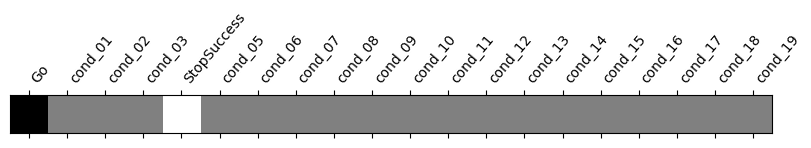

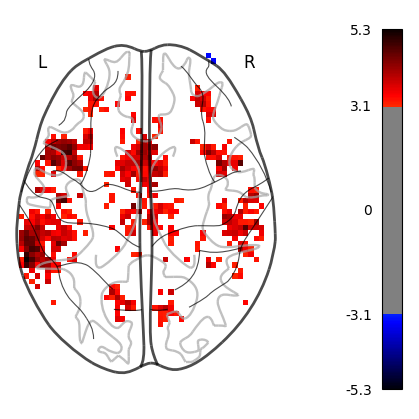

In [ ]:
from nilearn.plotting import plot_contrast_matrix
from scipy.stats import norm
import matplotlib.pyplot as plt

plot_contrast_matrix("StopSuccess - Go", design_matrix)
plotting.plot_glass_brain(
    z_map,
    colorbar=True,
    threshold=norm.isf(0.001),
    plot_abs=False,
    display_mode="z",
    figure=plt.figure(figsize=(4, 4)),
)
plt.show()

We can get a table from a Pandas Dataframe for display and publication
purposes



In [ ]:
from nilearn.reporting import get_clusters_table

table = get_clusters_table(z_map, norm.isf(0.001), 10)
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-66.0,-45.0,22.0,5.307532,6300
1,1a,-66.0,-33.0,18.0,4.668929,
2,1b,-48.0,-36.0,14.0,4.534376,
3,1c,-57.0,-48.0,10.0,4.254210,
4,2,-42.0,15.0,26.0,4.918703,2520
5,2a,-51.0,9.0,34.0,4.715845,
6,2b,-42.0,9.0,30.0,4.683343,
7,2c,-57.0,12.0,38.0,4.587956,
8,3,57.0,-27.0,2.0,4.692869,504
9,3a,66.0,-27.0,2.0,3.664250,


## Saving model outputs to disk

We can now easily save the main results,
the model metadata and an HTML report to the disk.




<ipython-input-13-bfeaa3c43965>:6: UserWarning: Contrast name "StopSuccess - Go" changed to "stopsuccessMinusGo"
  save_glm_to_bids(
<ipython-input-13-bfeaa3c43965>:6: UserWarning: Contrast name "StopSuccess - Go" changed to "stopsuccessMinusGo"
  save_glm_to_bids(


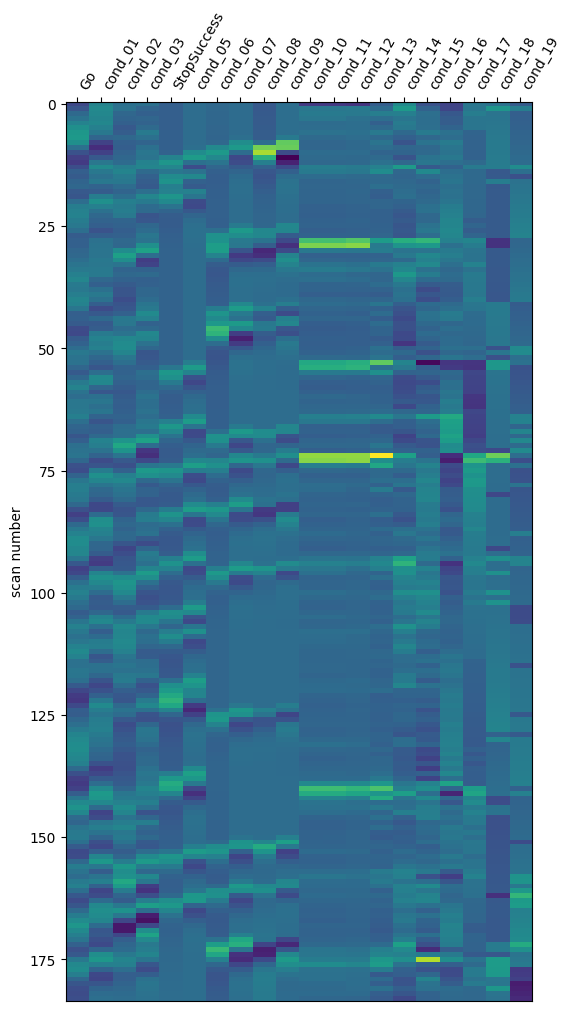

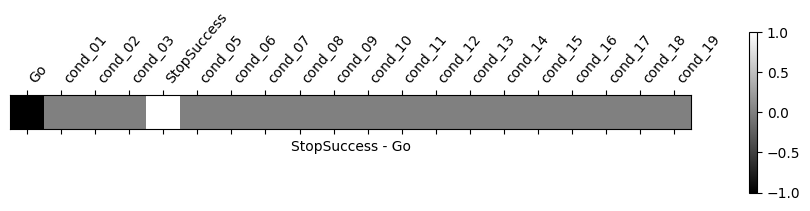

In [ ]:
output_dir = Path.cwd() / "results" / "plot_bids_features"
output_dir.mkdir(exist_ok=True, parents=True)

from nilearn.interfaces.bids import save_glm_to_bids

save_glm_to_bids(
    model,
    contrasts="StopSuccess - Go",
    contrast_types={"StopSuccess - Go": "t"},
    out_dir=output_dir / "derivatives" / "nilearn_glm",
    prefix=f"{subject}_task-stopsignal",
)

View the generated files



In [ ]:
files = sorted((output_dir / "derivatives" / "nilearn_glm").glob("**/*"))
print("\n".join([str(x.relative_to(output_dir)) for x in files]))

derivatives/nilearn_glm/dataset_description.json
derivatives/nilearn_glm/sub-10159
derivatives/nilearn_glm/sub-10159/sub-10159_task-stopsignal_contrast-stopsuccessMinusGo_design.svg
derivatives/nilearn_glm/sub-10159/sub-10159_task-stopsignal_contrast-stopsuccessMinusGo_stat-effect_statmap.nii.gz
derivatives/nilearn_glm/sub-10159/sub-10159_task-stopsignal_contrast-stopsuccessMinusGo_stat-p_statmap.nii.gz
derivatives/nilearn_glm/sub-10159/sub-10159_task-stopsignal_contrast-stopsuccessMinusGo_stat-t_statmap.nii.gz
derivatives/nilearn_glm/sub-10159/sub-10159_task-stopsignal_contrast-stopsuccessMinusGo_stat-variance_statmap.nii.gz
derivatives/nilearn_glm/sub-10159/sub-10159_task-stopsignal_contrast-stopsuccessMinusGo_stat-z_statmap.nii.gz
derivatives/nilearn_glm/sub-10159/sub-10159_task-stopsignal_design.json
derivatives/nilearn_glm/sub-10159/sub-10159_task-stopsignal_design.svg
derivatives/nilearn_glm/sub-10159/sub-10159_task-stopsignal_design.tsv
derivatives/nilearn_glm/sub-10159/sub-1015